# 1 `README`

*Read all of §1 before proceeding!*

In this notebook, we compare FACS with microscopy.

This notebook was written to be run in Google Colaboratory. To run, you will have to login to your Google Drive and enter an access token below. You can of course run the notebook offline if you install the modules used and change paths to point to local copies of the data.

## 1.1 Google Drive access

Run the cell below, click on the URL, login to your Google account, copy the code, enter it in the box below, hit enter.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


You need to make a shortcut to the shared `MicroTASBE` folder in your Drive home for the path below to be valid. The Drive interface (`google.colab.drive`) doesn't seem to be able to access shared folders otherwise.

In [2]:
path = '/content/drive/MyDrive/MicroTASBE'

# 2 Import

In [3]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import os
import pickle
import itertools
import scipy.stats
import sklearn.mixture
from glob import glob

In [4]:
dates = ["0630", "0624"]

In [5]:
def bin_plot(data, col, ax, bin_edges, colors=("#0000FF", "#FF0000", "#00FF00"), **kwargs):
  """
  Bin data based on values in one column. Plot a histogram for each bin, for each column.

  Parameters
  ----------
  data : pandas.DataFrame
    The data to bin. All columns will be plotted, so filter the columns first.
  col
    The column in `data` on which to bin.
  ax : list of list of matplotlib.axes.Axes
    A collection of axes on which to plot.
  bin_edges : array-like
    The edges of the bins. Should have dimension compatible with `ax`.
  colors : array-like, optional
    A list of colors to use.
  kwargs : dict, optional
    Keyword arguments passed to `matplotlib.axes.Axes.hist`.
  """
  colors = itertools.cycle(colors)

  # get bin edges like [(0, 1), (1, 2), (2, 3), ...]
  z = (bin_edges[:-1], bin_edges[1:])
  s = data[col]
  binned = [data[np.logical_and(s > l, s < r)] for l, r in zip(*z)]

  for ar, c in zip(ax, data.columns):
    color = next(colors)
    for a, d in zip(ar, binned):
      s = d[c]
      bins = np.logspace(*np.log10([bin_edges[0], bin_edges[-1]]))
      a.hist(s, bins=bins, color=color, **kwargs)

  return binned

In [6]:
def get_fig(r, c, xscale="log", yscale="log", figsize=(12, 8)):
  fig, ax = plt.subplots(r, c, squeeze=False,
                         sharex=True, sharey=True, figsize=figsize, 
                         subplot_kw={"xscale": xscale, "yscale": yscale})
  return fig, ax

In [7]:
# colors in plot
c1 = ("#000088", "#880000", "#008800")
c2 = ("#0000FF", "#FF0000", "#00FF00")

p = ((0, 0), 0, 0)
handles = [[Rectangle(*p, color=color1), Rectangle(*p, color=color2)] for color1, color2 in zip(c1, c2)]
labels = [dates,]*3
legend_kw = {
    "ncol": 2, 
    "columnspacing": 1.0,
    "handletextpad": 0.25,
    "handlelength": 0.75,
    "loc": "upper left"
}

# 3 Microscopy

## 3.1 Setup

In [8]:
data_path = os.path.join(path, "iPyNotebooksFromTim", "mefls")
micro = {d: {} for d in dates}

for date in micro:
  for unit in ("mefl", "au"):
    fname = f"{date}_ex_{unit}_data.pickle"
    with open(os.path.join(data_path, fname), 'rb') as fp:
      micro[date][unit] = pickle.load(fp)

In [9]:
# columns to use in plot, rows in the plot are in the same order as this list
chan_fmt = "Intensity_IntegratedIntensity_{}"
micro_cols = [chan_fmt.format(color) for color in ["blue", "red", "green"]]

# bin on blue
micro_col = chan_fmt.format("blue")

## 3.2 Arbitrary units

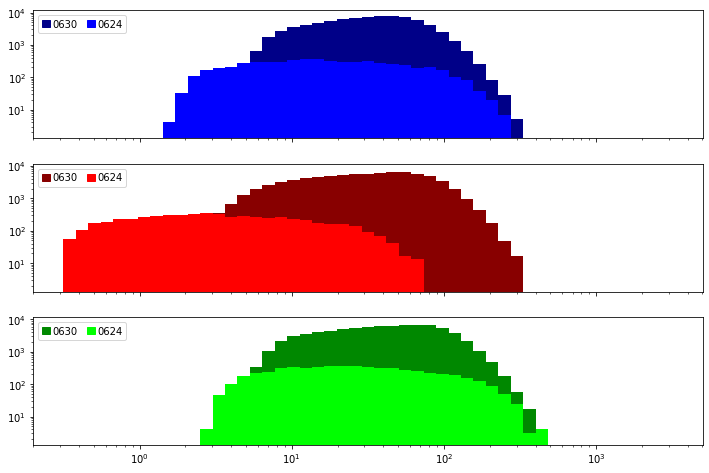

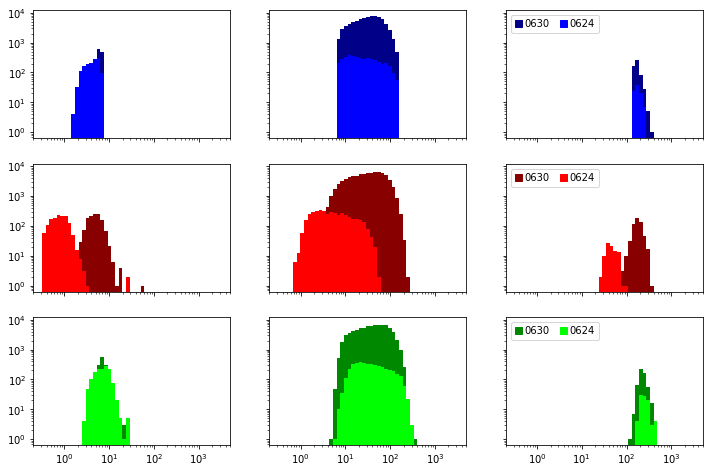

In [10]:
micro_au_b = {}
for s in (2, 4):
  bins = np.logspace(-0.5, 3.5, s)

  fig, ax = get_fig(len(micro_cols), len(bins)-1, yscale="log")
  for ar, h, l in zip(ax, handles, labels):
    ar[-1].legend(h, l, **legend_kw)

  for k, c in zip(dates, (c1, c2)):
    data = micro[k]["au"][micro_cols]
    micro_au_b[k] = bin_plot(data, micro_col, ax, bin_edges=bins, colors=c);

## 3.3 MEFL

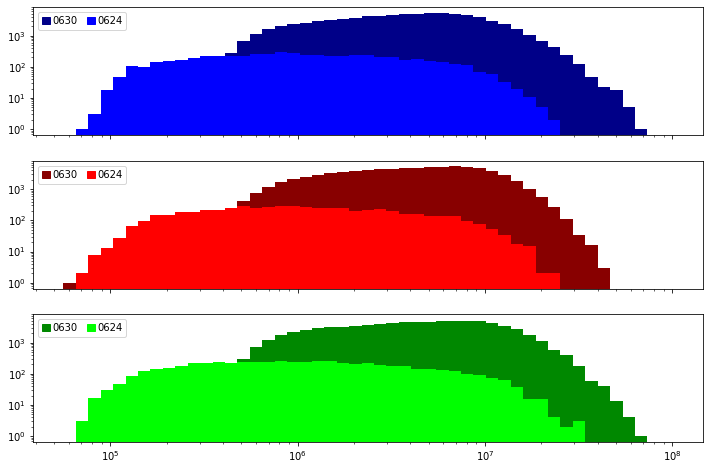

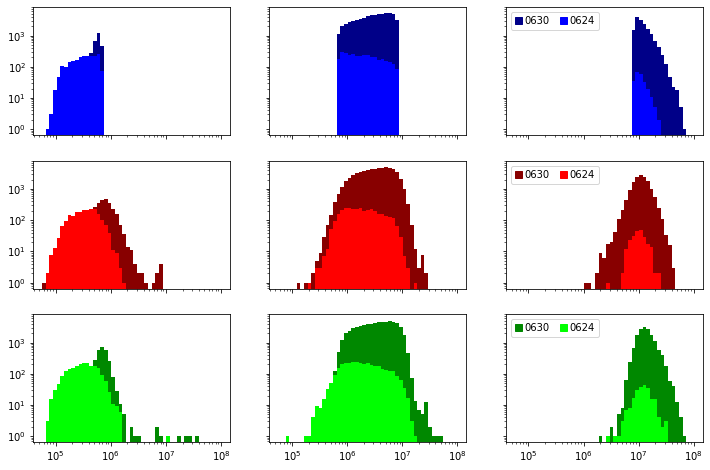

In [11]:
for s in (2, 4):
  bins = np.logspace(4.75, 8, s)

  fig, ax = get_fig(len(micro_cols), len(bins)-1)
  for ar, h, l in zip(ax, handles, labels):
    ar[-1].legend(h, l, **legend_kw)

  for k, c in zip(dates, (c1, c2)):
    data = micro[k]["mefl"][micro_cols]
    bin_plot(data, micro_col, ax, bin_edges=bins, colors=c);

# 4 FACS

## 4.1 Setup

In [12]:
base_path = os.path.join(path, "2D_Data", "ColorControls")
facs = {d: {} for d in dates}

for date in facs:
  dataset_path = os.path.join(base_path, f"Kiwimagi{date}2020", "FACsData")
  for unit in ("au", "mefl"):
    facs[date][unit] = {key: pd.DataFrame() for key in ("red", "green", "blue", "multi", "wildtype")}
    csv_path = os.path.join(dataset_path, f"csvFiles_{unit.upper()}")
    for fname in glob(os.path.join(csv_path, "*.csv")):
      chan = os.path.basename(fname).rstrip(".csv").split("-")[0].lower()
      facs[date][unit][chan] = facs[date][unit][chan].append(pd.read_csv(fname)) # Files -1.csv, -2.csv etc. are technical replicates

In [13]:
# columns to use in plot, rows in the plot are in the same order as this list
facs_cols = ["Pacific Blue-A", "PE-Texas Red-A", "FITC-A"]

# bin on blue
facs_col = facs_cols[0]

In [14]:
print(facs["0630"]["mefl"]["red"].columns)

Index(['Unnamed: 0', 'AmCyan-A', 'FSC-A', 'FSC-H', 'FSC-W', 'PE-A',
       'PerCP-Cy5-5-A', 'Rep', 'SSC-A', 'SSC-H', 'SSC-W', 'SampleName',
       'SampleType', 'Time', 'Morpho1', 'Morpho2', 'FITC-A', 'Pacific Blue-A',
       'PE-Texas Red-A'],
      dtype='object')


| FACS | color |
| :- | :- |
| FITC-A | green |
| Pacific Blue-A | blue |
| PE-Texas Red-A | red |

### 4.1.1 Gaussian mixture model

+ [`sklearn.mixture.GaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)
+ [`cytoflow.operations.gaussian`](https://github.com/cytoflow/cytoflow/blob/master/cytoflow/operations/gaussian.py)

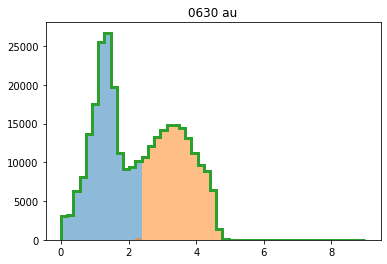

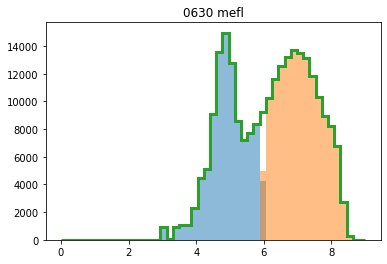

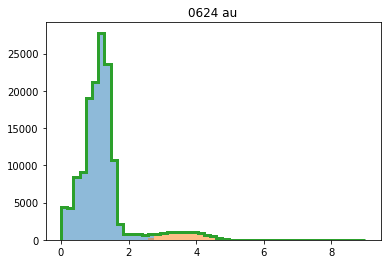

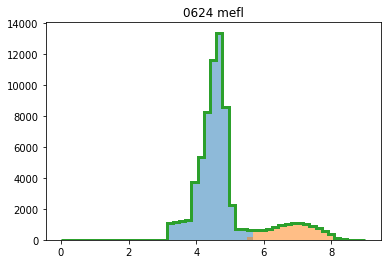

In [15]:
bins = np.linspace(0, 9)
facs_gmm = {}
for date in facs:
  facs_gmm[date] = {}
  for unit in facs[date]:
    d = facs[date][unit]["multi"][facs_cols]
    t = d[d[facs_col] > 0]
    x = np.log10(t[facs_col].values)
    gmm = sklearn.mixture.GaussianMixture(n_components=2, covariance_type="full", random_state=1)
    l = gmm.fit_predict(x.reshape(-1, 1))
    if scipy.stats.gmean(t[l == 0][facs_col]) > scipy.stats.gmean(t[l == 1][facs_col]):
      l = l ^ 1 # will not be congruent with gmm object anymore
    fig, ax = plt.subplots()
    ax.hist(x[l == 0], alpha=0.5, bins=bins)
    ax.hist(x[l == 1], alpha=0.5, bins=bins)
    ax.hist(x, histtype="step", lw=3, bins=bins)
    facs_gmm[date][unit] = {"multi": t[l == 1]}
    plt.title(f"{date} {unit}")

## 4.2 Arbitrary units

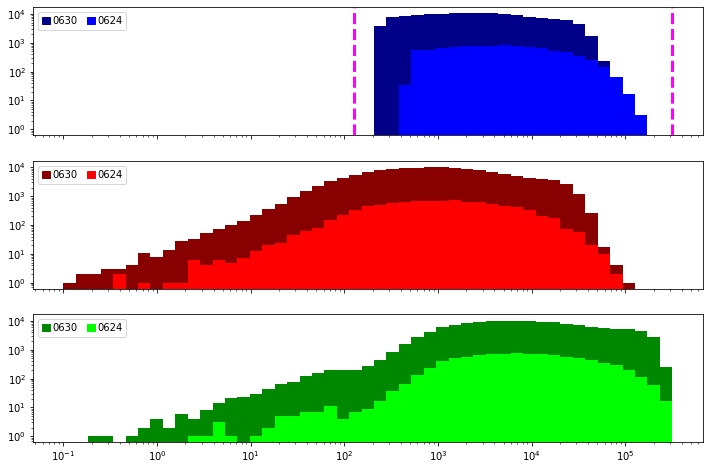

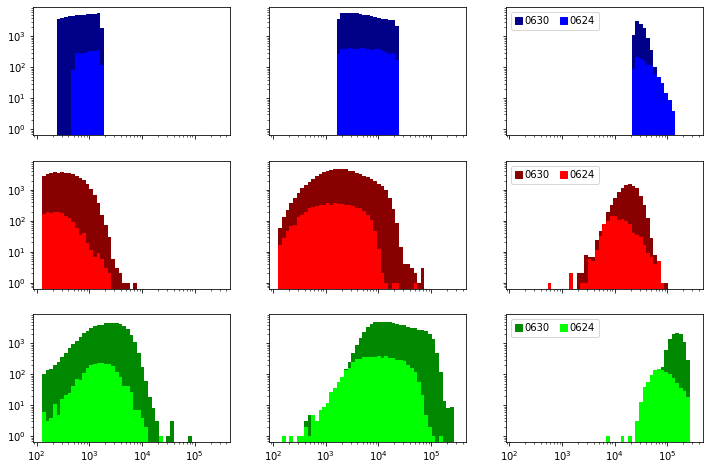

In [16]:
bl = 2.1
bh = 5.5
for i, bins in enumerate([
                          np.logspace(-1, bh, 2),
                          np.logspace(bl, bh, 4)
]):
  fig, ax = get_fig(len(facs_cols), len(bins)-1, yscale="log")
  for ar, h, l in zip(ax, handles, labels):  # channel / row
    ar[-1].legend(h, l, **legend_kw)

  for k, c in zip(dates, (c1, c2)):  # date
    data = facs_gmm[k]["au"]["multi"][facs_cols]
    bin_plot(data[data > 0], facs_col, ax, bin_edges=bins, colors=c);

  if i == 0:
    ax[0][-1].axvline(10**bl, color='magenta', ls="--", lw=3)
    ax[0][-1].axvline(10**bh, color='magenta', ls="--", lw=3)

## 4.3 MEFL

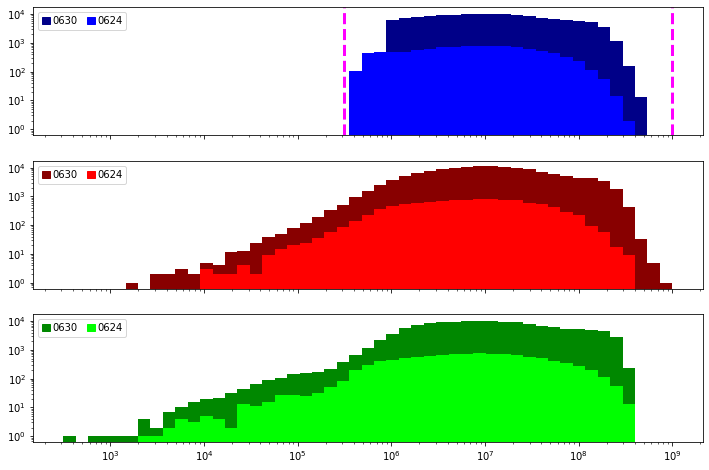

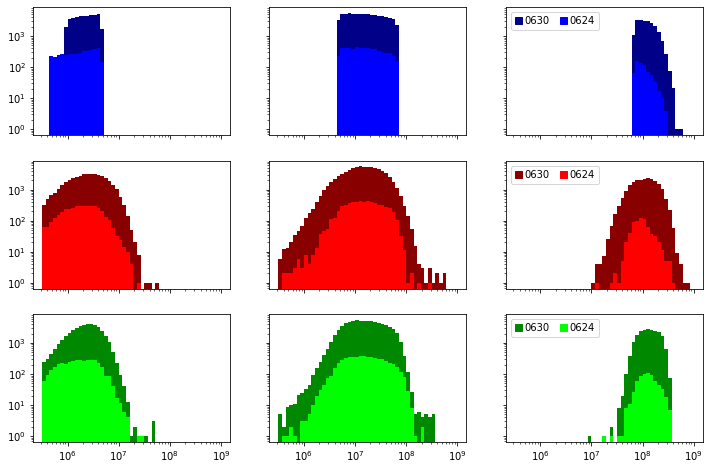

In [17]:
bl = 5.5
bh = 9
for i, bins in enumerate([
                          np.logspace(2.5, bh, 2),
                          np.logspace(bl, bh, 4)
]):
  fig, ax = get_fig(len(facs_cols), len(bins)-1, yscale="log")
  for ar, h, l in zip(ax, handles, labels):
    ar[-1].legend(h, l, **legend_kw)

  for k, c in zip(dates, (c1, c2)):
    data = facs_gmm[k]["mefl"]["multi"][facs_cols]
    bin_plot(data, facs_col, ax, bin_edges=bins, colors=c);

  if i == 0:
    ax[0][-1].axvline(10**bl, color='magenta', ls="--", lw=3)
    ax[0][-1].axvline(10**bh, color='magenta', ls="--", lw=3)

# 5 Combined plots

In [18]:
lw = 3

In [19]:
rect_kw = {"fill": None, "linewidth": lw}
c_handles = [[Rectangle(*p, color=color1),
              Rectangle(*p, color=color2),
              Rectangle(*p, edgecolor=color1, **rect_kw), 
              Rectangle(*p, edgecolor=color2, **rect_kw)] 
             for color1, color2 in zip(c1, c2)]
c_labels = [f"{d} {inst}" for inst in ("μ", "f") for d in dates]

## 5.1 Arbitrary units

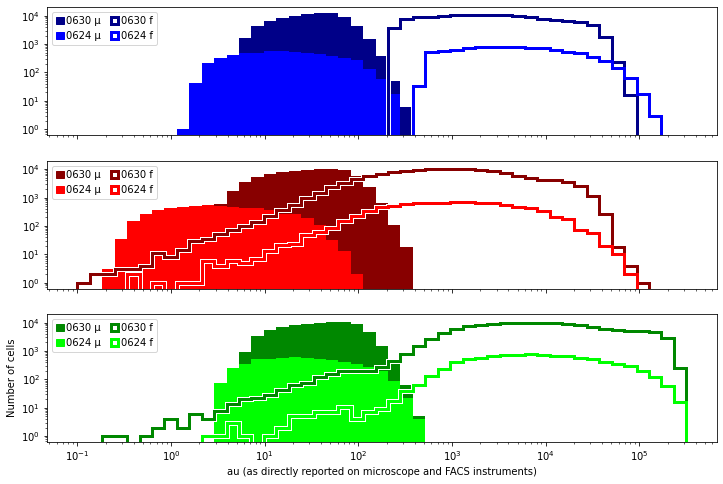

In [20]:
bins = [0.1, 10**(5.5)]

facs_b = {}
micro_b = {}

fig, ax = get_fig(len(micro_cols), len(bins)-1)
for ar, h in zip(ax, c_handles):
  ar[-1].legend(h, c_labels, **legend_kw)

for k, c in zip(dates, (c1, c2)):
  data = micro[k]["au"][micro_cols]
  b = bin_plot(data, micro_col, ax, bin_edges=bins, colors=c, zorder=10)
  micro_b[k] = b

for k, c in zip(dates, (c1, c2)):
  data = facs_gmm[k]["au"]["multi"][facs_cols]
  b = bin_plot(data, facs_col, ax, bin_edges=bins, colors=c, histtype="step", lw=lw, zorder=20)
  b = bin_plot(data, facs_col, ax, bin_edges=bins, colors=('white',)*3, histtype="step", lw=lw+2, zorder=18)
  facs_b[k] = b

ax[-1][0].set_xlabel("au (as directly reported on microscope and FACS instruments)")
ax[-1][0].set_ylabel("Number of cells")

pass

## 5.2 MEFL

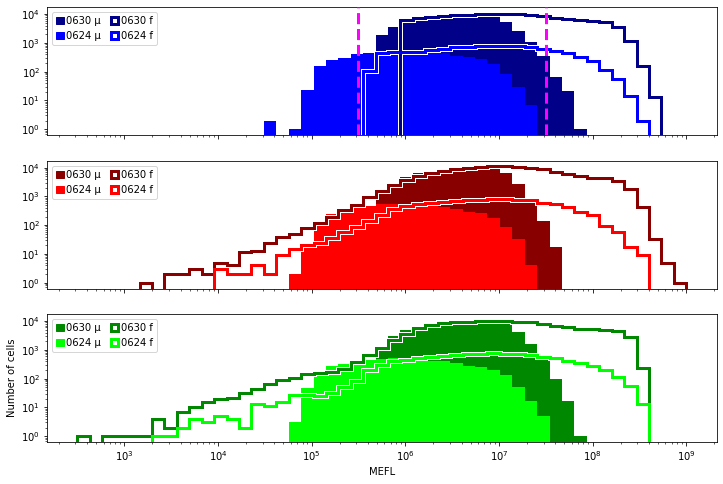

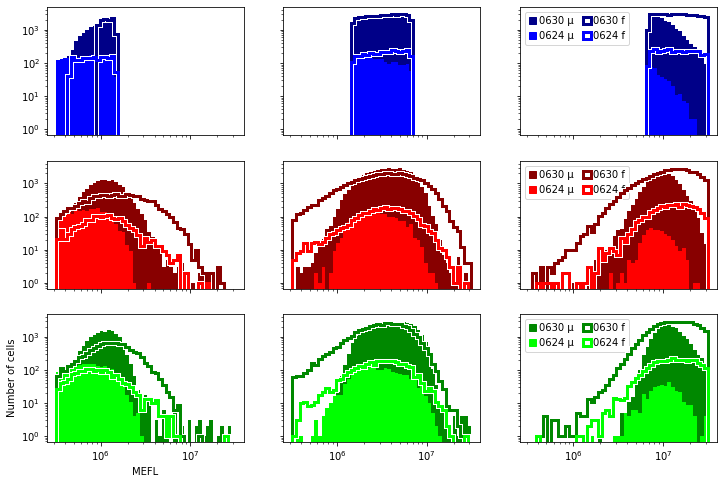

In [21]:
c_bl = 5.5
c_bh = 7.5
for i, bins in enumerate([
             np.logspace(2.5, 9, 2),
             np.logspace(c_bl, c_bh, 4)
]):
  facs_b = {}
  micro_b = {}

  fig, ax = get_fig(len(micro_cols), len(bins)-1)
  for ar, h in zip(ax, c_handles):
    ar[-1].legend(h, c_labels, **legend_kw)

  for k, c in zip(dates, (c1, c2)):
    data = micro[k]["mefl"][micro_cols]
    b = bin_plot(data, micro_col, ax, bin_edges=bins, colors=c, zorder=10)
    if len(bins) > 2:
      micro_b[k] = b

  for k, c in zip(dates, (c1, c2)):
    data = facs_gmm[k]["mefl"]["multi"][facs_cols]
    b = bin_plot(data, facs_col, ax, bin_edges=bins, colors=c, histtype="step", lw=lw, zorder=20)
    b = bin_plot(data, facs_col, ax, bin_edges=bins, colors=('white',)*3, histtype="step", lw=lw+2, zorder=18)
    if len(bins) > 2:
      facs_b[k] = b

  if i == 0:
    ax[0][-1].axvline(10**c_bl, color='magenta', zorder=100, lw=3, ls="--")
    ax[0][-1].axvline(10**c_bh, color='magenta', zorder=100, lw=3, ls="--")
    
  ax[-1][0].set_xlabel("MEFL")
  ax[-1][0].set_ylabel("Number of cells")

pass

## 5.3 Statistical distance

+ [Wikipedia:Statistical_distance](https://en.wikipedia.org/wiki/Statistical_distance)
+ [Statistical distances in `scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-distances)
  + Wasserstein distance (a.k.a. Earth mover's distance)
    + [`scipy.stats.wasserstein_distance`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html)
    + [Wikipedia:Wasserstein_metric](https://en.wikipedia.org/wiki/Wasserstein_metric)
    + [Wikipedia:Earth_mover's_distance](https://en.wikipedia.org/wiki/Earth_mover%27s_distance)
  + Energy distance
    + [`scipy.stats.energy_distance`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.energy_distance.html)
    + [Wikipedia:Energy_distance](https://en.wikipedia.org/wiki/Energy_distance)


### 5.3.1 FACS versus microscopy

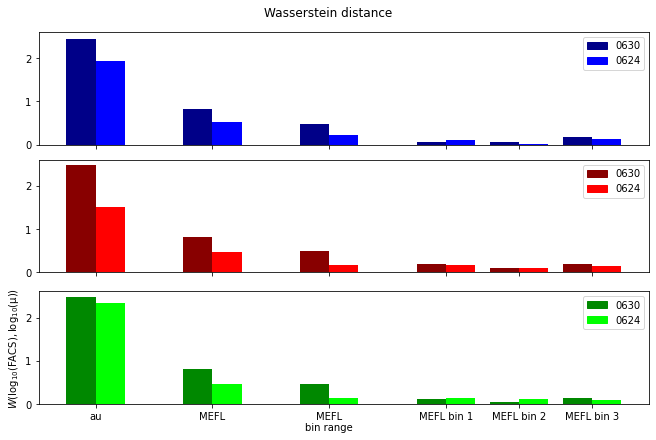

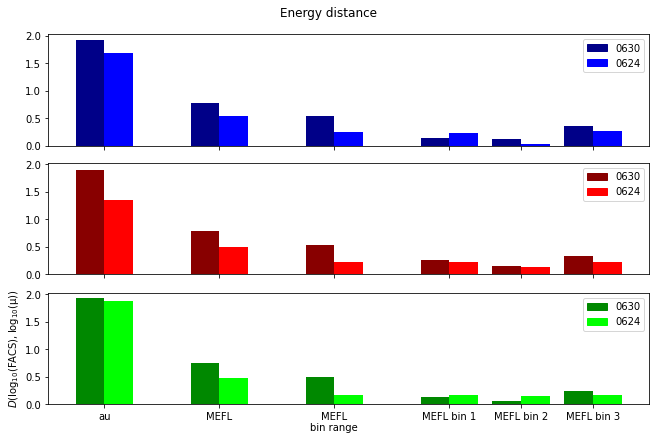

In [22]:
nbin = 3
for func, title, l in [[scipy.stats.wasserstein_distance, "Wasserstein distance", "W"], 
                       [scipy.stats.energy_distance, "Energy distance", "D"]]:
  fig, ax = plt.subplots(nbin, 1, sharey=True, sharex=True, figsize=(9, 6), constrained_layout=True)
  width = 0.1
  sep = width*(len(dates) + 1)
  colors = (c1, c2)
  for k, (cf, cm, a) in enumerate(zip(facs_cols, micro_cols, ax)):
    a.set_yscale("linear")
    for i, date in enumerate(reversed(dates)):
      w = []
      # au
      u = facs_gmm[date]["au"]["multi"][cf]
      u = np.log10(u[u > 0])
      v = micro[date]["au"][cm]
      v = np.log10(v[v > 0])
      w.append(func(u, v))
      # MEFL whole
      u = facs_gmm[date]["mefl"]["multi"][cf]
      u = np.log10(u[u > 0])
      v = micro[date]["mefl"][cm]
      v = np.log10(v[v > 0])
      w.append(func(u, v))
      # MEFL binned all
      u = facs_gmm[date]["mefl"]["multi"][cf]
      up = facs_gmm[date]["mefl"]["multi"][facs_col]
      u = u[np.logical_and(up > 10**c_bl, up < 10**c_bh)]
      u = np.log10(u)
      v = micro[date]["mefl"][cm]
      vp = micro[date]["mefl"][micro_col]
      v = v[np.logical_and(vp > 10**c_bl, vp < 10**c_bh)]
      v = np.log10(v)
      w.append(func(u, v))
      # MEFL binned
      for j, (bf, bm) in enumerate(zip(facs_b[date], micro_b[date])):
        u = np.log10(bf[cf])
        v = np.log10(bm[cm])
        w.append(func(u, v))
      x = np.arange(nbin + 3)*0.25 + i*width
      x[1:] = x[1:] + 1.5*width
      x[2:] = x[2:] + 1.5*width
      x[3:] = x[3:] + 1.5*width
      a.bar(x, w, width=width, color=colors[i][k])
    h = [Rectangle(*p, color=c[k]) for c in colors] 
    a.legend(handles=h, labels=dates)
  ax[-1].set_xticks(x - 0.5*width)
  ax[-1].set_xticklabels(["au", "MEFL", "MEFL\nbin range"] + [f"MEFL bin {i}" for i in range(1, nbin+1)])
  ax[-1].set_ylabel(f"${l}(\log_{{10}}(\mathrm{{FACS}}), \log_{{10}}(\mathrm{{\mu}}))$")
  fig.suptitle(title);

### 5.3.2 Microscopy only: 0624 vs 0630

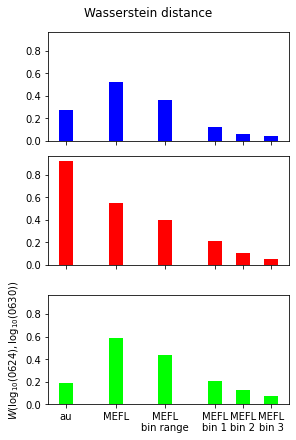

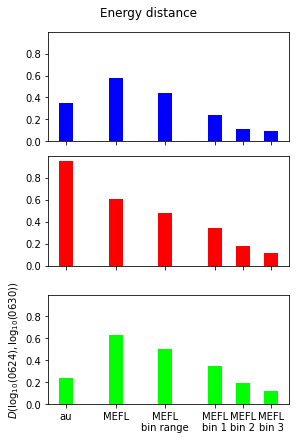

In [24]:
nbin = 3
for func, title, l in [[scipy.stats.wasserstein_distance, "Wasserstein distance", "W"], 
                       [scipy.stats.energy_distance, "Energy distance", "D"]]:
  fig, ax = plt.subplots(nbin, 1, sharey=True, sharex=True, figsize=(4, 6), constrained_layout=True)
  width = 0.1
  sep = width*(len(dates) + 1)
  for k, (cm, a) in enumerate(zip(micro_cols, ax)):
    a.set_yscale("linear")
    w = []
    u = micro["0624"]["au"][cm]
    u = np.log10(u[u > 0])
    v = micro["0630"]["au"][cm]
    v = np.log10(v[v > 0])
    w.append(func(u, v))
    # MEFL whole
    u = micro["0624"]["mefl"][cm]
    u = np.log10(u[u > 0])
    v = micro["0630"]["mefl"][cm]
    v = np.log10(v[v > 0])
    w.append(func(u, v))
    # MEFL binned all
    u = micro["0624"]["mefl"][cm]
    up = micro["0624"]["mefl"][micro_col]
    u = u[np.logical_and(up > 10**c_bl, up < 10**c_bh)]
    u = np.log10(u)
    v = micro["0630"]["mefl"][cm]
    vp = micro["0630"]["mefl"][micro_col]
    v = v[np.logical_and(vp > 10**c_bl, vp < 10**c_bh)]
    v = np.log10(v)
    w.append(func(u, v))
    # MEFL binned
    for j, (bma, bmb) in enumerate(zip(micro_b["0624"], micro_b["0630"])):
      u = np.log10(bma[cm])
      v = np.log10(bmb[cm])
      w.append(func(u, v))
    x = np.arange(nbin + 3)*2*width + i*width
    for i in range(1, 3+1):
      x[i:] = x[i:] + 1.5*width
    a.bar(x, w, width=width, color=c2[k])
  ax[-1].set_xticks(x)
  ax[-1].set_xticklabels(["au", "MEFL", "MEFL\nbin range"] + [f"MEFL\nbin {i}" for i in range(1, nbin+1)])
  ax[-1].set_ylabel(f"${l}(\log_{{10}}(\mathrm{{0624}}), \log_{{10}}(\mathrm{{0630}}))$")
  fig.suptitle(title);

In [ ]:
c_bl = 5.5
c_bh = 7.5
for i, bins in enumerate([
             np.logspace(2.5, 9, 2),
             np.logspace(c_bl, c_bh, 4)
]):
  facs_b = {}
  micro_b = {}

  fig, ax = get_fig(len(micro_cols), len(bins)-1)
  for ar, h in zip(ax, c_handles):
    ar[-1].legend(h, c_labels, **legend_kw)

  for k, c in zip(dates, (c1, c2)):
    data = micro[k]["mefl"][micro_cols]
    b = bin_plot(data, micro_col, ax, bin_edges=bins, colors=c, zorder=10)
    if len(bins) > 2:
      micro_b[k] = b

  for k, c in zip(dates, (c1, c2)):
    data = facs_gmm[k]["mefl"]["multi"][facs_cols]
    b = bin_plot(data, facs_col, ax, bin_edges=bins, colors=c, histtype="step", lw=lw, zorder=20)
    b = bin_plot(data, facs_col, ax, bin_edges=bins, colors=('white',)*3, histtype="step", lw=lw+2, zorder=18)
    if len(bins) > 2:
      facs_b[k] = b

  if i == 0:
    ax[0][-1].axvline(10**c_bl, color='magenta', zorder=100, lw=3, ls="--")
    ax[0][-1].axvline(10**c_bh, color='magenta', zorder=100, lw=3, ls="--")
    
  ax[-1][0].set_xlabel("MEFL")
  ax[-1][0].set_ylabel("Number of cells")

pass